# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [17]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [18]:
i = 8# Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc") # Model output

# subset = xarray.open_dataset(f"{base_folder}/dataset.nc") # Raw data
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc") # Cleaned data (pixels with quality flags > 3 or temperature > 40 removed)
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc") # Cleaned data with simulated clouds added

In [19]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
sea_mask = cleanup_clouds["mask"].values.astype(bool) # 1 = water, 0 = land

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, sea_mask.dtype, sea_mask.shape

((7149, 106, 149),
 (7149, 106, 149),
 (7149, 106, 149),
 dtype('bool'),
 (106, 149))

In [20]:
# Calculate in which days the clouds were applied

added_clouds = np.ones((N, 2), dtype=int)

for i in range(N):
    missing_values = sum(np.isnan(cleanup_sst[i].flatten()))
    missing_values_clouds = sum(np.isnan(cleanup_clouds_sst[i].flatten()))
    n_pixels = missing_values_clouds - missing_values
    added_clouds[i, 0] = i  # Store the day index
    added_clouds[i, 1] = n_pixels

# Sort added_clouds by the number of pixels with clouds (second column)
added_clouds = added_clouds[added_clouds[:, 1].argsort()]

print("# Days with clouds:", len(added_clouds))

# Days with clouds: 7149


In [21]:
added_clouds

array([[  24,    0],
       [  22,    0],
       [7128,    0],
       ...,
       [6921, 5700],
       [4290, 5712],
       [3892, 5780]], shape=(7149, 2))

In [22]:
cloud_mask = np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_imgs = np.where(cloud_mask, result_sst, cleanup_sst)

In [23]:
np.nanmin(reconstructed_imgs), np.nanmax(reconstructed_imgs)

(np.float32(-207.39462), np.float32(334.7903))

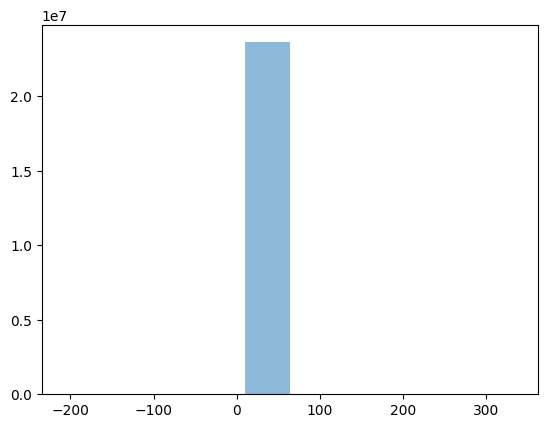

In [24]:
# plt.hist(cleanup_sst.flatten(), bins=10, alpha=0.5)
plt.hist(reconstructed_imgs.flatten(), bins=10, alpha=0.5)
plt.show()

In [25]:
np.nanmin(result_sst)

np.float32(-279.44775)

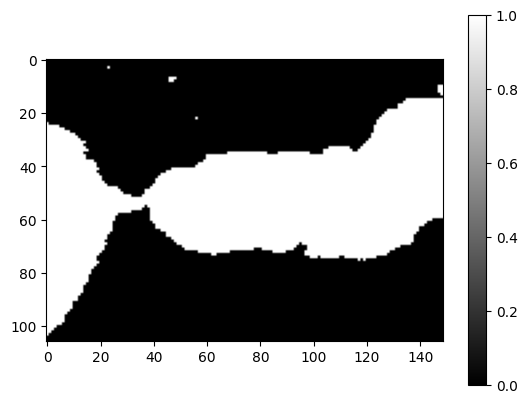

In [26]:
plt.imshow(sea_mask, cmap='gray')
plt.colorbar()

/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_63726/1607237747.py:18: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)


RMSE:
 Model: 4.185472011566162
 Mean: 0.22030951082706451
Min: 0.6890011429786682, Max: 39.98999786376953


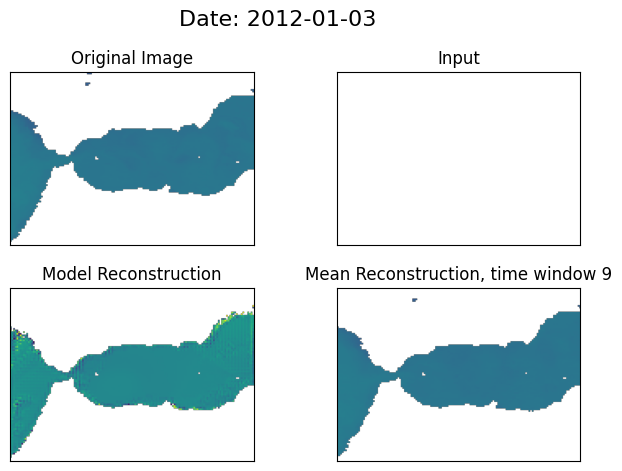

In [36]:
time_window = 9 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day
    
i = np.random.choice(added_clouds[-1, :])  # Randomly select a day with added clouds
# i = added_clouds[-2, 0]
reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]

date = cleanup.time[i].values.astype('datetime64[D]')
# The applied clouds are where cleanup_clouds_sst is NaN but and the original image isn't
cloud_mask = np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i])

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = np.where(cloud_mask, result_sst[i], cleanup_sst[i])
reconstructed_img = np.where(reconstructed_img < 0, np.nan, reconstructed_img)
reconstructed_img = np.where(reconstructed_img > 40, np.nan, reconstructed_img)

# Calculate the mean of the surrounding days
mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)
# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = np.where(cloud_mask, mean_res, cleanup_sst[i])

# Calculate RMSE between the reconstructed and original images
RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_mean}")

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)
# fig.suptitle(f"RMSE Model: {RMSE_model:.2f}, RMSE Mean: {RMSE_mean:.2f}", fontsize=16)
fig.suptitle(f"Date: {date}", fontsize=16)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title(f'Mean Reconstruction, time window {time_window}')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# plt.colorbar(axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax),
#              ax=axs,
#              orientation='horizontal')
plt.show()

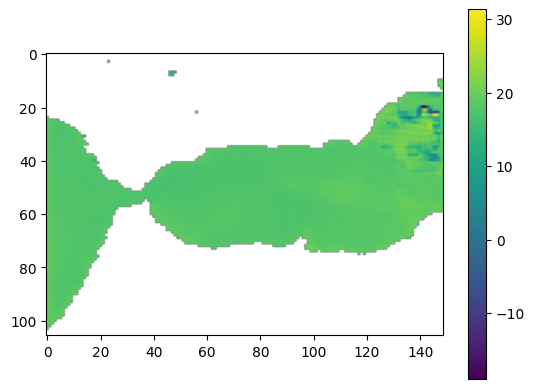

In [ ]:
plt.imshow(result_sst[i])
plt.colorbar()

## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [ ]:
# Calculate where the clouds were applied, only considering water areas
mask = np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

In [ ]:
RMSE_rec = []
RMSE_mean = []

for i in range(n_days, N - n_days):
   
    if not mask[i].any(): # If no clouds were applied, skip this iteration
        continue

    diff = (result_sst[i] - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue
    rec = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for reconstruction

    reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
    mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days
    diff = (mean_res - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue

    mn = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for mean reconstruction

    if np.isnan(rec) or np.isnan(mn):
        print(f"Skipping {i} due to NaN values in RMSE calculations.")
        continue
        
    RMSE_rec.append(rec)
    RMSE_mean.append(mn)

print("Number of valid RMSE values:", len(RMSE_rec))
print("Mean RMSE Reconstruction:", np.mean(RMSE_rec))
print("Mean RMSE Mean:", np.mean(RMSE_mean))


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_63726/4164045493.py:15: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days


Number of valid RMSE values: 994
Mean RMSE Reconstruction: 2.122817
Mean RMSE Mean: 0.8851347


## Plot the loss

In [ ]:
with open(base_folder + 'loss.txt', 'r') as f:
    loss = f.read()
    
loss = loss.split('\n')

loss = [float(x) for x in loss if x]  # Convert to float and remove empty strings

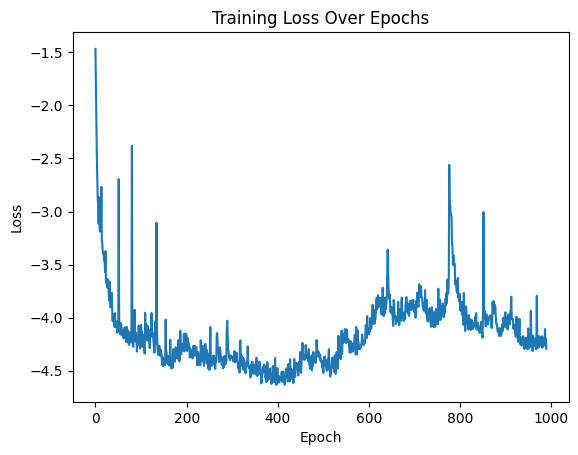

In [41]:
plt.plot(loss[10:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()